In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

sns.set_style("whitegrid")

### EX 6.2

In [4]:
df = pd.read_table("glucose.dat", names=['glucose'])
nrv = stats.norm(loc=df.glucose.mean(), scale=df.glucose.std())
xs = np.linspace(25, 230, num=10000)

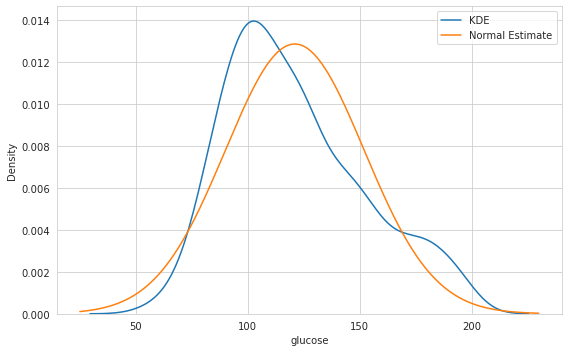

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.kdeplot(df.glucose, label="KDE", ax=ax)
ax.plot(xs, nrv.pdf(xs), label="Normal Estimate")
ax.legend()

fig.tight_layout()
fig.show()

In [98]:
def semi_normal_prec_post(y, prior_var, prior_sample, mean):
    n = y.shape[0]
    post_sample = prior_sample + n
    post_var = 1/post_sample * (prior_var*prior_sample + ((y-mean)**2).sum())

    return post_sample, post_var

def semi_normal_mean_post(y, prior_mean, prior_var, prec):
    n = y.shape[0]
    prior_prec = 1 / prior_var

    post_prec = prior_prec + n * prec
    post_mean = (prior_prec * prior_mean + y.sum() * prec) / post_prec

    return post_mean, 1/post_prec

np.random.seed(235234)

# observations
Y = df = pd.read_table("glucose.dat", names=['glucose']).glucose
N = Y.shape[0]

# prior parameters
a = b = 1
θ_mean0, θ_var0 = 120, 200
γ_var0, γ_sample0 = 1000, 10

# initization
n_epochs = 10000
samples = []

p = 0.5
θ1, γ1 = Y.mean(), 1/Y.var()
θ2, γ2 = θ1, γ1

for epoch in range(n_epochs):
    Y_p1 = p * stats.norm(loc=θ1, scale=np.sqrt(1/γ1)).pdf(Y)
    Y_p2 = (1-p) * stats.norm(loc=θ2, scale=np.sqrt(1/γ2)).pdf(Y)
    p_N = Y_p1 / (Y_p1 + Y_p2)
    X = np.random.binomial(1, p_N, N) + 1
    N1, N2 = (X==1).sum(), (X==2).sum()

    p = np.random.beta(a+N1, b+N2)

    γ1_post_sample, γ1_post_var = semi_normal_prec_post(Y[X==1], γ_var0, γ_sample0, θ1)
    γ2_post_sample, γ2_post_var = semi_normal_prec_post(Y[X==2], γ_var0, γ_sample0, θ2)
    γ1 = np.random.gamma(γ1_post_sample/2, 1/(γ1_post_var*γ1_post_sample/2))
    γ2 = np.random.gamma(γ2_post_sample/2, 1/(γ2_post_var*γ2_post_sample/2))

    θ1_post_mean, θ1_post_var = semi_normal_mean_post(Y[X==1], θ_mean0, θ_var0, γ1)
    θ2_post_mean, θ2_post_var = semi_normal_mean_post(Y[X==2], θ_mean0, θ_var0, γ2)
    θ1 = np.random.normal(θ1_post_mean, np.sqrt(θ1_post_var))
    θ2 = np.random.normal(θ2_post_mean, np.sqrt(θ2_post_var))

    # y posterior
    if np.random.uniform() < p:
        y_post = np.random.normal(θ1, np.sqrt(1/γ1))
    else:
        y_post = np.random.normal(θ2, np.sqrt(1/γ2))

    samples.append((p, θ1, θ2, γ1, γ2, y_post))

S = pd.DataFrame(samples, columns=['p', 'theta_1', 'theta_2', 'gamma_1', 'gamma_2', 'y_post'])

<AxesSubplot:xlabel='y_post', ylabel='Density'>

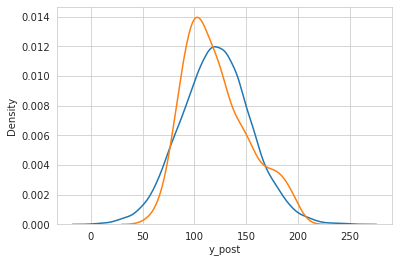

In [99]:
sns.kdeplot(S['y_post'])
sns.kdeplot(Y)

<AxesSubplot:>

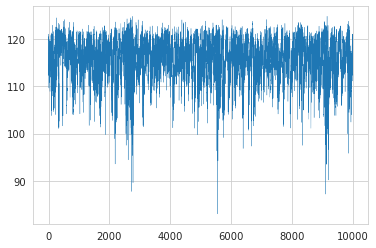

In [82]:
S.apply(lambda x: min(x['theta_1'],x['theta_2']), axis=1).plot(linewidth=0.3)

<AxesSubplot:>

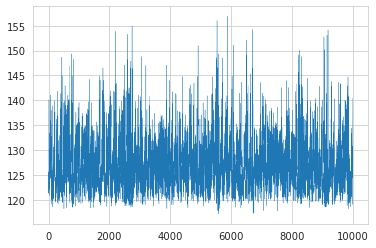

In [94]:
S.apply(lambda x: max(x['theta_1'],x['theta_2']), axis=1).plot(linewidth=0.3)

<AxesSubplot:>

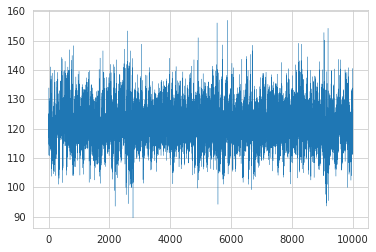

In [95]:
S['theta_1'].plot(linewidth=0.3)